In [144]:
import xarray as xr
import collections, math
import numpy as np
import pandas as pd
from osgeo import gdal, gdal_array, osr
%matplotlib inline

In [10]:
ds_all=xr.open_mfdataset(
    '/g/data/oe9/project/team-drip/h30v12_reflectance_????.nc',
    chunks=dict(time=12, x=1200), #chunks should be in multiples of saved chunk size
)

In [102]:
#function for reprojecting modis sinusoidal to lat/lon
AffineGeoTransform = collections.namedtuple(
    'GeoTransform', ['origin_x', 'pixel_width', 'x_rot',
                     'origin_y', 'y_rot', 'pixel_height'])


def get_geot(ds):
    """Take an Xarray object with x and y coords; return geotransform."""
    return AffineGeoTransform(*map(float, (
        # Affine matrix - start/step/rotation, start/rotation/step - in 1D
        ds.x[0], (ds.x[-1] - ds.x[0]) / ds.x.size, 0,
        ds.y[0], 0, (ds.y[-1] - ds.y[0]) / ds.y.size
    )))


## set bounding box around data (can be larger than data area
class aus:
    start_lat = -30
    stop_lat = -37
    start_lon = 138
    stop_lon = 153

out_res_degrees = 0.005

ll_geot = AffineGeoTransform(
    origin_x=aus.start_lon, pixel_width=out_res_degrees, x_rot=0,
    origin_y=aus.start_lat, y_rot=0, pixel_height=-out_res_degrees
)

new_shape = (
    math.ceil((aus.start_lat - aus.stop_lat) / out_res_degrees),
    math.ceil((aus.stop_lon - aus.start_lon) / out_res_degrees),
)

ll_coords = dict(
    latitude=np.arange(new_shape[0]) * ll_geot.pixel_height + ll_geot.origin_y,
    longitude=np.arange(new_shape[1]) * ll_geot.pixel_width + ll_geot.origin_x,
    )

# MAGIC - describes the MODIS projection
wkt_str = (
    'PROJCS["Sinusoidal",GEOGCS["GCS_Undefined",DATUM["Undefined",'
    'SPHEROID["User_Defined_Spheroid",6371007.181,0.0]],PRIMEM["Greenwich",0.0],'
    'UNIT["Degree",0.0174532925199433]],PROJECTION["Sinusoidal"],'
    'PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],'
    'PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]"'
)


# Next, define some generically useful functions:


def project_array(array, geot=None):
    """Reproject a tile from Modis Sinusoidal to WGS84 Lat/Lon coordinates.
    Metadata is handled by the calling function.
    """
    # Takes around seven seconds per layer for in-memory Australia mosaics
    if geot is None:
        geot = get_geot(array)
    assert isinstance(geot, AffineGeoTransform)

    def array_to_raster(array, geot):
        ysize, xsize = array.shape  # unintuitive order, but correct!
        dataset = gdal.GetDriverByName('MEM').Create(
            '', xsize, ysize,
            eType=gdal_array.NumericTypeCodeToGDALTypeCode(array.dtype))
        dataset.SetGeoTransform(geot)
        dataset.SetProjection(wkt_str)
        dataset.GetRasterBand(1).WriteArray(array)
        return dataset

    if isinstance(array, xr.DataArray):
        array = array.values
    input_data = array_to_raster(array, geot)

    # Set up the reference systems and transformation
    from_sr = osr.SpatialReference()
    from_sr.ImportFromWkt(wkt_str)
    to_sr = osr.SpatialReference()
    to_sr.SetWellKnownGeogCS("WGS84")

    # Get new geotransform and create destination raster
    dest_arr = np.empty(new_shape)
    dest_arr[:] = np.nan
    dest = array_to_raster(dest_arr, ll_geot)

    # Perform the projection/resampling
    gdal.ReprojectImage(
        input_data, dest,
        wkt_str, to_sr.ExportToWkt(),
        gdal.GRA_NearestNeighbour)
    
    return xr.DataArray(
        dest.GetRasterBand(1).ReadAsArray(),
        dims=('latitude', 'longitude'),
        coords=ll_coords)

In [29]:
# rename vars for simple calcs
blue = ds_all.blue_450_520
green = ds_all.green_530_610
red = ds_all.red_630_690
nir1 = ds_all.nir1_780_900
nir2 = ds_all.nir2_1230_1250
ndvi = (nir1 - red) / (nir1 + red)
ndvi

<xarray.DataArray (time: 1564, y: 1680, x: 2400)>
dask.array<shape=(1564, 1680, 2400), dtype=float32, chunksize=(12, 1680, 1200)>
Coordinates:
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
  * time     (time) datetime64[ns] 2001-01-01 2001-01-05 2001-01-09 ...

## test with time slice

In [183]:
dat = ndvi.isel(time=0).load()
dat

<xarray.DataArray (y: 1680, x: 2400)>
array([[0.116172, 0.119227, 0.119014, ..., 0.561992, 0.606901, 0.582184],
       [0.109407, 0.116157, 0.118683, ..., 0.576499, 0.575383, 0.613897],
       [0.116788, 0.117059, 0.117854, ..., 0.563195, 0.592681, 0.593033],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
    time     datetime64[ns] 2001-01-01

In [187]:
dat_ll=project_array(dat)
dat_ll.coords['time'] = dat.time
dat_ll

<xarray.DataArray (latitude: 1400, longitude: 3000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 -30.0 -30.0 -30.01 -30.02 -30.02 -30.02 ...
  * longitude  (longitude) float64 138.0 138.0 138.0 138.0 138.0 138.0 138.0 ...
    time       datetime64[ns] 2001-01-01

In [176]:
out=xr.concat([dat_ll],'time')
out['time']=dat.time
out


<xarray.DataArray (time: 1, latitude: 1400, longitude: 3000)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * latitude   (latitude) float64 -30.0 -30.0 -30.01 -30.02 -30.02 -30.02 ...
  * longitude  (longitude) float64 138.0 138.0 138.0 138.0 138.0 138.0 138.0 ...
    time       datetime64[ns] 2001-01-01

In [172]:
# data = np.ones((360,720))
# lats = np.arange(-89.75, 90, 0.5) * -1
# lngs = np.arange(-179.75, 180, 0.5)
# coords =  {'lat': lats, 'lng': lngs, 'time': dat.time}
# da = xr.DataArray(data, coords=coords, dims=['lat', 'lng'])
# expanded_da = xr.concat([da], 'time')

# expanded_da
# da


<xarray.DataArray (lat: 360, lng: 720)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 87.75 87.25 86.75 86.25 ...
  * lng      (lng) float64 -179.8 -179.2 -178.8 -178.2 -177.8 -177.2 -176.8 ...
    time     datetime64[ns] 2001-01-01

In [191]:
some_ndvi = ndvi[:5].load()
some_ndvi

<xarray.DataArray (time: 5, y: 1680, x: 2400)>
array([[[0.116172, 0.119227, ..., 0.606901, 0.582184],
        [0.109407, 0.116157, ..., 0.575383, 0.613897],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[0.113727, 0.116849, ..., 0.609402, 0.584578],
        [0.107788, 0.116094, ..., 0.572227, 0.62833 ],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[0.116424, 0.117159, ..., 0.559195, 0.530572],
        [0.108828, 0.115191, ..., 0.538415, 0.544369],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[0.117425, 0.118323, ..., 0.5382  , 0.514968],
        [0.1104  , 0.115594, ..., 0.533062, 0.5356  ],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]]], 

In [200]:
#  for step in dat.time:
#     out = xr.concat([project_array(dat.sel(step))], dat.time)

out = xr.concat(
    [project_array(some_ndvi.sel(time=step)) for step in some_ndvi.time], 
    dim=some_ndvi.time)
out

<xarray.DataArray (time: 5, latitude: 1400, longitude: 3000)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01 2001-01-05 2001-01-09 ...
  * latitude   (latitude) float64 -30.0 -30.0 -30.01 -30.02 -30.02 -30.02 ...
  * longitude  (longitude) float64 138.0 138.0 138.0 138.0 138.0 138.0 138.0 ...

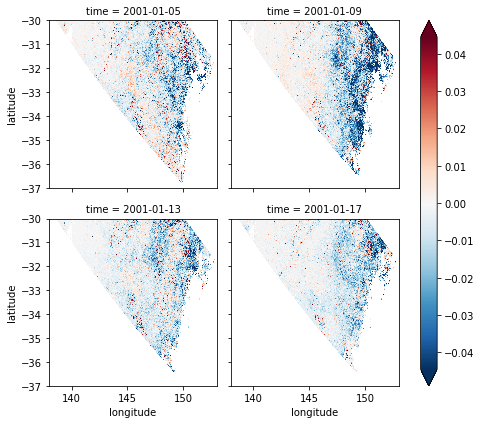

In [204]:
out.diff('time').plot.imshow(col='time', robust=True, col_wrap=2)

## Generate .ncs


In [20]:
%%time
for year in range(2001, 2018):
    
    
    fname = '/g/data/oe9/project/team-drip/h30v12_ndvi_ll_{}.nc'.format(year)
    if os.path.isfile(fname):
        print('already done', fname)
        continue        
    try:
        ndvi.sel(time=str(year)).to_netcdf(fname)
    except Exception as e:
        print('Year {} failed with {}'.format(year, type(e)))
        print(e)


<xarray.DataArray (time: 92, y: 1680, x: 2400)>
dask.array<shape=(92, 1680, 2400), dtype=float32, chunksize=(12, 1680, 1200)>
Coordinates:
  * x        (x) float64 1.334e+07 1.334e+07 1.334e+07 1.334e+07 1.335e+07 ...
  * y        (y) float64 -3.336e+06 -3.336e+06 -3.337e+06 -3.337e+06 ...
  * time     (time) datetime64[ns] 2001-01-01 2001-01-05 2001-01-09 ...

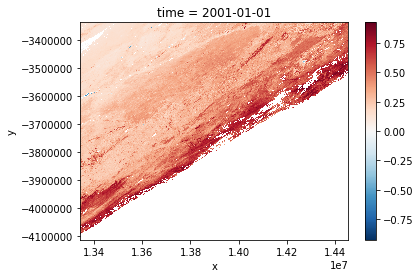

In [11]:
fig, axes = plt.subplots(ncols=2)
ndvi.isel(time=0).plot.imshow(ax=axes[0])
ndvi_ll.isel(time=0).plot.imshow(ax=axes[1])
plt.tight_layout()